In [ ]:
!pip install transformers
!pip install matplotlib
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Loading annotations exported from Label Studio as a json file.

In [1]:
import json

with open('../data/sample/sample.json') as f:
    data = json.load(f)

In [2]:
len(data)

35

35 images were annotated.

In [3]:
data[0].keys()

dict_keys(['id', 'annotations', 'predictions', 'file_upload', 'data', 'meta', 'created_at', 'updated_at', 'project'])

An annotation for a single image is a dictionary. Everything which is interesting for us is in the `annotations` value.

In [4]:
data[0]['annotations'][0].keys()

dict_keys(['id', 'completed_by', 'result', 'was_cancelled', 'ground_truth', 'created_at', 'updated_at', 'lead_time', 'prediction', 'result_count', 'task'])

And specifically in the `result` value inside.

Below functions to format annotations before implementing the `Dataset` class.

In [65]:
from typing import Dict

def format_image_annotations(image_annotations: Dict):
    """
    Formats the annotations for a single image.
    """
    words = []
    boxes = []
    labels = []
    
    for annotation in image_annotations['result']:
        value = annotation['value']
        if 'rectanglelabels' not in value.keys():
            continue
        # x, y, width, height are already normalized and in 0-100
        # For LayoutLMv2 we want them in 0-1000
        x = value['x']
        y = value['y']
        width = value['width']
        height = value['height']
        rotation = value['rotation']

        # ignoring the rotation parameter for now
        #  [x1, y1, x3, y3] format
        x1 = 10 * x
        y1 = 10 * (100 - y - height)
        # y1 = 10 * (y + height)
        x3 = 10 * (x + width)
        y3 = 10 * (100 - y)
        # y3 = 10 * y
        
        boxes.append([int(coord) for coord in [x1, y1, x3, y3]])
        words.append(annotation['meta']['text'][0])
        labels.append(value['rectanglelabels'][0])
    
    return words, labels, boxes

In [66]:
from typing import List

def format_annotations(annotations: List):
    """
    Format all annotations.
    """
    words = []
    boxes = []
    labels = []
    
    for image_full_annotations in annotations:
        image_annotations = image_full_annotations['annotations'][0]
        image_words, image_labels, image_boxes = format_image_annotations(image_annotations)
        words.append(image_words)
        boxes.append(image_boxes)
        labels.append(image_labels)
    
    return words, labels, boxes

We format all annotations using the `format_annotations` function.

In [67]:
formatted_annotations = format_annotations(data)

Now we implement the `Dataset` class.

In [68]:
def get_image_paths(annotations: List):
    """
    Gets image paths from annotations.
    """
    image_paths = []
    for image_annotations in annotations:
        image_paths.append(image_annotations['data']['image'])
    return image_paths

image_paths = get_image_paths(data)

In [69]:
image_names = [path[21:] for path in image_paths]

In [70]:
image_paths = ['../data/sample/' + name for name in image_names]
image_paths

['../data/sample/2022-02-02_repas_les jardins de presbourg.jpg',
 '../data/sample/2022-01-25_repas_la cantine de belleville.jpg',
 '../data/sample/2022-02-15_achat_la poste.jpg',
 '../data/sample/2022-03-28_repas_la comete.jpg',
 '../data/sample/20221108_230713.jpg',
 '../data/sample/20221019_091203.jpg',
 '../data/sample/20221030_123439.jpg',
 '../data/sample/2022-03-22_achat_la poste.jpg',
 '../data/sample/20221108_230510.jpg',
 '../data/sample/20221105_133703.jpg',
 '../data/sample/20221019_091208.jpg',
 '../data/sample/20221108_230524.jpg',
 '../data/sample/2022-03-10_achat_la poste.jpg',
 '../data/sample/IMG_20221107_211244.jpg',
 '../data/sample/2022-03-06_achat_darty.jpg',
 '../data/sample/20221108_230653.jpg',
 '../data/sample/20221030_123424.jpg',
 '../data/sample/2022-03-06_achat_le divan.jpg',
 '../data/sample/20221117_120342.jpg',
 '../data/sample/20221108_230535.jpg',
 '../data/sample/20221018_185931.jpg',
 '../data/sample/20221105_133551.jpg',
 '../data/sample/20221105_22

In [71]:
all_labels = [item for sublist in formatted_annotations[1] for item in sublist]
labels = list(set(all_labels))
label2id = {label: idx for idx, label in enumerate(labels)}

label2id

{'total_price': 0,
 'code_tva': 1,
 'item_quantity': 2,
 'item_unit_price': 3,
 'item_name': 4,
 'taux_tva': 5,
 'magasin': 6,
 'date': 7,
 'item_total_price': 8}

In [72]:
id2label = {idx: label for idx, label in enumerate(labels)}
id2label

{0: 'total_price',
 1: 'code_tva',
 2: 'item_quantity',
 3: 'item_unit_price',
 4: 'item_name',
 5: 'taux_tva',
 6: 'magasin',
 7: 'date',
 8: 'item_total_price'}

In [73]:
from os import listdir
from torch.utils.data import Dataset
import torch
from PIL import Image

class TicketsDataset(Dataset):
    """Tickets dataset."""

    def __init__(self, annotations, image_paths: List[str], processor=None, max_length=512):
        """
        Args:
            annotations (List[List]): List of lists containing the word-level annotations (words, labels, boxes).
            image_paths (string): Directory with all the document images.
            processor (LayoutLMv2Processor): Processor to prepare the text + image.
        """
        self.words, self.labels, self.boxes = annotations
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # first, take an image
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")

        # get word-level annotations 
        words = self.words[idx]
        boxes = self.boxes[idx]
        word_labels = self.labels[idx]

        assert len(words) == len(boxes) == len(word_labels)

        word_labels = [label2id[label] for label in word_labels]
        # use processor to prepare everything
        encoded_inputs = self.processor(image, words, boxes=boxes, word_labels=word_labels, 
                                        padding="max_length", truncation=True, 
                                        return_tensors="pt")
        
        # remove batch dimension
        for k,v in encoded_inputs.items():
            encoded_inputs[k] = v.squeeze()

        assert encoded_inputs.input_ids.shape == torch.Size([512])
        assert encoded_inputs.attention_mask.shape == torch.Size([512])
        assert encoded_inputs.token_type_ids.shape == torch.Size([512])
        assert encoded_inputs.bbox.shape == torch.Size([512, 4])
        assert encoded_inputs.image.shape == torch.Size([3, 224, 224])
        assert encoded_inputs.labels.shape == torch.Size([512]) 
      
        return encoded_inputs

In [74]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")
train_dataset = TicketsDataset(annotations=formatted_annotations,
                               image_paths=image_paths,
                               processor=processor)

In [75]:
train_dataset

On vérifie un exemple.

In [76]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

Test localisation des bbox sur l'image.

In [77]:
encoding['bbox'].shape

torch.Size([512, 4])

In [78]:
encoding['bbox']

tensor([[  0,   0,   0,   0],
        [ 40, 904, 343, 934],
        [ 40, 904, 343, 934],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]])

In [79]:
encoding['labels'].shape

torch.Size([512])

In [80]:
encoding['image'].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

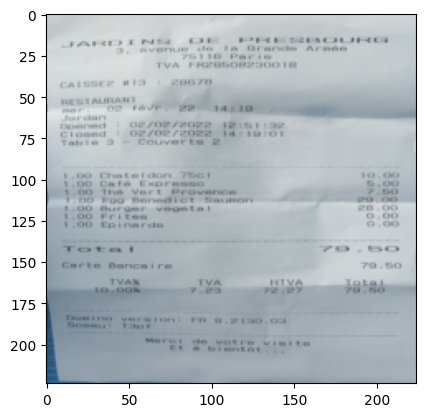

In [81]:
from matplotlib import pyplot as plt

plt.imshow(encoding['image'].permute(1, 2, 0))

In [82]:
encoding['bbox'][1] / 1000 * 224

tensor([  8.9600, 202.4960,  76.8320, 209.2160])

In [83]:
encoding['labels'][1]

tensor(6)

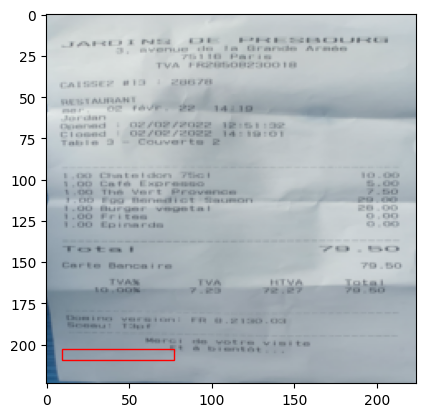

In [84]:
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(encoding['image'].permute(1, 2, 0))

# Create a Rectangle patch
resized_bbox = encoding['bbox'][1] / 1000 * 224
rect = patches.Rectangle((resized_bbox[0], resized_bbox[1]), resized_bbox[2] - resized_bbox[0], resized_bbox[3] - resized_bbox[1], 
                         linewidth=1,
                         edgecolor='r',
                         facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

Test entraînement

In [85]:
print(processor.tokenizer.decode(encoding['input_ids']))

[CLS] jardins de presbourg mer. 02 fevr. 22 1. 00 chateldon 75cl 1. 00 cafe expresso 1. 00 the vert provence 1. 00 egg benedict saumon 1. 00 burger vegetal 1. 00 frites 1. 00 epinards 10. 00 5. 00 7. 50 29. 00 28. 00 0. 00 0. 00 79. 50 10. 00 % [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [86]:
formatted_annotations[0][0]

['JARDINS',
 'DE',
 'PRESBOURG',
 'mer.',
 '02',
 'févr.',
 '22',
 '1.00',
 'Chateldon',
 '75cl',
 '1.00',
 'Café',
 'Expresso',
 '1.00',
 'Thé',
 'Vert',
 'Provence',
 '1.00',
 'Egg',
 'Benedict',
 'Saumon',
 '1.00',
 'Burger',
 'vegetal',
 '1.00',
 'Frites',
 '1.00',
 'Epinards',
 '10.00',
 '5.00',
 '7.50',
 '29.00',
 '28.00',
 '0.00',
 '0.00',
 '79.50',
 '10.00%']

In [87]:
formatted_annotations[1][0]

['magasin',
 'magasin',
 'magasin',
 'date',
 'date',
 'date',
 'date',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_quantity',
 'item_name',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'total_price',
 'taux_tva']

In [88]:
[id2label[label] for label in encoding['labels'].tolist() if label != -100]

['magasin',
 'magasin',
 'magasin',
 'date',
 'date',
 'date',
 'date',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_name',
 'item_quantity',
 'item_name',
 'item_quantity',
 'item_name',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'item_total_price',
 'total_price',
 'taux_tva']

In [89]:
for id, label in zip(encoding['input_ids'][:30], encoding['labels'][:30]):
    print(processor.tokenizer.decode([id]), label.item())

[CLS] -100
jar 6
##din -100
##s -100
de 6
pre 6
##sb -100
##our -100
##g -100
mer 7
. -100
02 7
fe 7
##vr -100
. -100
22 7
1 2
. -100
00 -100
chat 4
##eld -100
##on -100
75 4
##cl -100
1 2
. -100
00 -100
cafe 4
express 4
##o -100


Création de DataLoaders

In [90]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

Entraînement

In [91]:
from transformers import LayoutLMv2ForTokenClassification, AdamW
import torch
from tqdm.notebook import tqdm

model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                         num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 4

# Put the model in training mode
model.train() 
for epoch in range(num_train_epochs):  
    print("Epoch:", epoch)
    for batch in tqdm(train_dataloader):
        # get the inputs;
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=input_ids,
                        bbox=bbox,
                        image=image,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=labels) 
        loss = outputs.loss

        # print loss every 100 steps
        if global_step % 100 == 0:
            print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForTokenClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.20.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.11.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.14.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv3.norm.num_batches_tracke

Epoch: 0


  0%|          | 0/18 [00:00<?, ?it/s]

Loss after 0 steps: 2.2134244441986084


FileNotFoundError: [Errno 2] No such file or directory: '../data/sample/IMG_20221107_211244.jpg'